In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

from tqdm import tqdm
from scipy import stats
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import (
    LogisticRegressionCV,
    LassoCV,
    Lasso,
    ElasticNetCV,
    LogisticRegression,
)

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold

sys.path.append(os.path.abspath("../"))
from dmldid.model_rcs import DMLDiD_RCS

# original data + fixed data processing process
- There is a bug in the data processing process in Chang(2020).
- Minimal processing process fixed.

## setup

In [2]:
DATA_PATH = "data/Bribes_Regression.dta"

df = pd.read_stata(DATA_PATH)
df = df.rename(columns={"lba": "Y", "tariff_change_2008": "D", "post_2008": "T"})
del df["day_w_arrival_post2008"]
del df['psi_post_2008']
df = pd.concat(
    [
        df,
        pd.get_dummies(df["reason_bribe"], drop_first=False, prefix="reason_bribe"),
        pd.get_dummies(df["b_recipient"], drop_first=False, prefix="b_recipient"),
        pd.get_dummies(df["day_w_arrival"], drop_first=False, prefix="day_w_arrival"),
        pd.get_dummies(df["monitor"], drop_first=False, prefix="monitor"),
        pd.get_dummies(df["psi"], drop_first=False, prefix="psi"),
        pd.get_dummies(df["term"], drop_first=False, prefix="term"),
        pd.get_dummies(df["clear_agent"].fillna(-1).astype(int), drop_first=False, prefix="clear_agent"),
        pd.get_dummies(df["hc_group"].fillna(-1).astype(int), drop_first=False, prefix="hc_group"),
    ],
    axis=1,
).drop(
    [
        "reason_bribe",
        "b_recipient",
        "day_w_arrival",
        "monitor",
        "psi",
        "term",
        "clear_agent",
        "hc_group",
    ],
    axis=1,
)

df.head().T

,0,1,2,3,4
ship_id,1.0,2.0,3.0,4.0,5.0
month_arrival,12.0,3.0,12.0,8.0,8.0
year,1.0,4.0,1.0,4.0,4.0
hc_4digits,9405.0,8215.0,2202.0,8703.0,8703.0
bp,NaN,0.0,1.0,1.0,0.0
...,...,...,...,...,...
hc_group_11,0.0,0.0,0.0,0.0,0.0
hc_group_12,0.0,1.0,0.0,0.0,0.0
hc_group_13,0.0,0.0,0.0,0.0,0.0
hc_group_14,0.0,0.0,0.0,1.0,1.0


In [3]:
X_cols = [
    "tariff2007",
    "lvalue_tonnage",
    "differentiated",
    "agri",
    "perishable",
    "dfs",
    "rsa",
]
monitor_cols = [col for col in df.columns if "monitor" in col]
dwa_cols = [col for col in df.columns if "day_w_arrival" in col]
psi_cols = [col for col in df.columns if "psi" in col]
clear_agent_cols = [col for col in df.columns if "clear_agent" in col]
hc_group_cols = [col for col in df.columns if "hc_group" in col]

In [4]:
X_cols = X_cols + dwa_cols + monitor_cols + psi_cols + clear_agent_cols + hc_group_cols
y_col = "Y"
d_col = "D"
t_col = "T"

## Chang (2020)
- The following R code is from [Chang (2020)](https://github.com/NengChiehChang/Diff-in-Diff/blob/master/Table%202/DMLML.R).
- DMLML:Unchanged except for the addition of a progress bar
- fixed_DMLML: The concept of Chang(2020) is unchanged. However, an obvious implementation error was corrected.

In [5]:
Y = df[X_cols + [y_col , d_col , t_col]].dropna().reset_index(drop=True)[[y_col]].to_numpy()
D = df[X_cols + [y_col , d_col , t_col]].dropna().reset_index(drop=True)[[d_col]].to_numpy()
T = df[X_cols + [y_col , d_col , t_col]].dropna().reset_index(drop=True)[[t_col]].to_numpy()
X = df[X_cols + [y_col , d_col , t_col]].dropna().reset_index(drop=True)[X_cols].astype(float).to_numpy()

In [6]:
%load_ext rpy2.ipython

In [7]:
%R  -i Y
%R  -i D
%R  -i T
%R  -i X

In [8]:
%%R
#Working data
Working_data=cbind(Y,D,T,X)

Working_data=Working_data[complete.cases(Working_data), ]

Y=Working_data[,1]
D=Working_data[,2]
T=Working_data[,3]
X=Working_data[,4:47]
index=t(combn(length(X[1,]),2))

library(glmnet)

p=X
DMLML=function(Y,D,p,T){
  N=length(Y)
  B=100
  set.seed(123)
  random=sample(1:1000,B)
  
  thetabar=c(0)
  pb <- txtProgressBar(min = 1, max = B, style = 3)
  for (l in 1:B){
    k=2
    setTxtProgressBar(pb, l)
    samplesplit=function(k,N){
      c1=1:N
      smp_size <- floor((1/k) * length(c1))
      
      ## set the seed to make your partition reproducible
      set.seed(random[l])
      train_ind <- sample(seq_len(length(c1)), size = smp_size)
      
      k1 <- c1[train_ind]
      k2 <- c1[-train_ind]
      return(rbind(k1,k2))
    }
    K=samplesplit(k,N)
    
    thetaDML=c(0)
    
    for (q in 1:k){
      ##Trimming
      set.seed(333)
      CV=cv.glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1)
      fit=glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1,lambda=CV$lambda.1se)
      beta1hat=fit$beta
      beta1hat <- as.numeric(as.character(beta1hat))
      
      ghat=1/(1+exp(-p[K[q,],]%*%beta1hat))
      #ghat = predict(fit, p[K[q,],], type="response")
      
      index1=K[q,][which(ghat<0.97 & ghat>0.03)]
      
      ##Estimation
      ghat=1/(1+exp(-p[index1,]%*%beta1hat))
      #ghat = predict(fit, p[index1,], type="response")
      
      lambda=mean(T[-K[q,]])
      
      index=which(D[-K[q,]]==0)
      YY=Y[-K[q,]]
      YY=YY[index]
      TT=T[-K[q,]]
      TT=TT[index]
      XX=p[-K[q,],]
      XX=XX[index,]
      
      set.seed(333)
      CV=cv.glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1)
      fit=glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1,lambda=CV$lambda.1se)
      
      beta2hat=fit$beta
      beta2hat <- as.numeric(as.character(beta2hat))
      
      ellhat2=p[index1,]%*%beta2hat
      #ellhat2 = predict(fit,p[index1,])
      
      
      s=((T[index1]-lambda)*Y[index1]-ellhat2)*(D[index1]-ghat)/(1-ghat)/(lambda*(1-lambda))/mean(D[index1])
      s=s[which(s<abs(min(s)))]
      
      thetaDML[q]=mean(s)
      
    }
    thetabar[l]=mean(thetaDML)
  }
  finaltheta=mean(thetabar)
  return(thetabar)
}

fixed_DMLML=function(Y,D,p,T){
  N=length(Y)
  B=100
  set.seed(123)
  random=sample(1:1000,B)
  
  thetabar=c(0)
  pb <- txtProgressBar(min = 1, max = B, style = 3)
  for (l in 1:B){
    k=2
    setTxtProgressBar(pb, l)
    samplesplit=function(k,N){
      c1=1:N
      smp_size <- floor((1/k) * length(c1))
      
      ## set the seed to make your partition reproducible
      set.seed(random[l])
      train_ind <- sample(seq_len(length(c1)), size = smp_size)
      
      k1 <- c1[train_ind]
      k2 <- c1[-train_ind]
      return(rbind(k1,k2))
    }
    K=samplesplit(k,N)
    
    thetaDML=c(0)
    
    for (q in 1:k){
      ##Trimming
      set.seed(333)
      CV=cv.glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1)
      fit=glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1,lambda=CV$lambda.1se)
      beta1hat=fit$beta
      beta1hat <- as.numeric(as.character(beta1hat))
      
      #ghat=1/(1+exp(-p[K[q,],]%*%beta1hat))
      ghat = predict(fit, p[K[q,],], type="response")
      
      index1=K[q,][which(ghat<0.97 & ghat>0.03)]
      
      ##Estimation
      #ghat=1/(1+exp(-p[index1,]%*%beta1hat))
      ghat = predict(fit, p[index1,], type="response")
      
      lambda=mean(T[-K[q,]])
      
      index=which(D[-K[q,]]==0)
      YY=Y[-K[q,]]
      YY=YY[index]
      TT=T[-K[q,]]
      TT=TT[index]
      XX=p[-K[q,],]
      XX=XX[index,]
      
      set.seed(333)
      CV=cv.glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1)
      fit=glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1,lambda=CV$lambda.1se)
      
      beta2hat=fit$beta
      beta2hat <- as.numeric(as.character(beta2hat))
      
      #ellhat2=p[index1,]%*%beta2hat
      ellhat2 = predict(fit,p[index1,])
      
      
      s=((T[index1]-lambda)*Y[index1]-ellhat2)*(D[index1]-ghat)/(1-ghat)/(lambda*(1-lambda))/mean(D[index1])
      # s=s[which(s
      
      thetaDML[q]=mean(s)
      
    }
    thetabar[l]=mean(thetaDML)
  }
  finaltheta=mean(thetabar)
  return(thetabar)
}
r_result = DMLML(Y,D,p,T)
fixed_r_result = fixed_DMLML(Y,D,p,T)

R[write to console]:  要求されたパッケージ Matrix をロード中です 

R[write to console]: Loaded glmnet 4.1-3



  |======================================================================| 100%

In [9]:
%R -o r_result
%R -o fixed_r_result

## modified model

In [10]:
linear_dmldid = DMLDiD_RCS()

lgbm_dmldid = DMLDiD_RCS(
    d_model=LGBMClassifier(random_state=0),
    l2k_model=LGBMRegressor(random_state=0),
)

In [11]:
linear_dmldid.fit(
    df[X_cols + [y_col , d_col , t_col]].dropna(),
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True,
)
algo_modified_bar = linear_dmldid.sim_att_result()

99. att :  1.4470091808080991


In [12]:
lgbm_dmldid.fit(
    df[X_cols + [y_col , d_col , t_col]].dropna(),
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True,
)
algo_modified_bar_lgbm = lgbm_dmldid.sim_att_result()

99. att :  2.1263134998932043


## Result

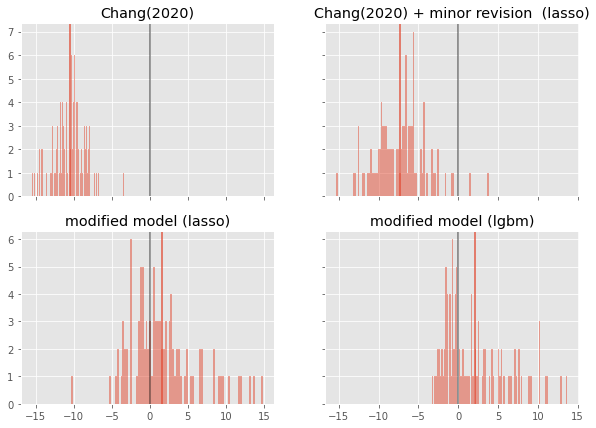

In [13]:
_label = [
    "Chang(2020)",
    "Chang(2020) + minor revision  (lasso)",
    "modified model (lasso)",
    "modified model (lgbm)",
]
result_df = pd.DataFrame(
    {
        "original_bar_r": r_result,
        "few_fixed_bar_r": fixed_r_result,
        "algo_modified_bar" : algo_modified_bar,
        "algo_modified_bar_lgbm": algo_modified_bar_lgbm,
    }
)
fig, ax = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 7))
ax = ax.ravel()
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    # ax[i].set_xlim(0,5)
    ax[i].set_title(_label[i])
    ax[i].axvline(x=0, alpha=0.5, color="black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()

In [14]:
result_df.describe().T

,count,mean,std,min,25%,50%,75%,max
original_bar_r,100.0,-10.513419,2.105609,-15.498212,-11.791510,-10.295733,-9.285189,-3.394286
few_fixed_bar_r,100.0,-7.306794,3.187346,-15.307697,-9.439364,-7.057944,-5.644996,3.855952
algo_modified_bar,100.0,1.569613,4.471456,-10.432355,-1.289278,0.717816,3.312236,14.859424
algo_modified_bar_lgbm,100.0,2.097376,4.054545,-3.333298,-0.988301,0.736988,4.530454,13.672448


In [15]:
print("Done")

Done
